# CNA CVE Stats By Type (Last Year)

In [13]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime, timedelta

## Load and Parse CVE Data

In [14]:
all_rows = []
base_dir = "CVE/cves"

# Loop through each year directory
for year_dir in os.listdir(base_dir):
    if year_dir.isdigit():
        year_path = os.path.join(base_dir, year_dir)
        if os.path.isdir(year_path):
            for root, dirs, files in os.walk(year_path):
                for filename in files:
                    if filename.endswith(".json"):
                        filepath = os.path.join(root, filename)
                        try:
                            with open(filepath, "r") as file:
                                cve_data = json.load(file)

                                meta = cve_data.get("cveMetadata", {})
                                containers = cve_data.get("containers", {})
                                cna = containers.get("cna", {})

                                cve_id = meta.get("cveId", None)
                                state = meta.get("state", None)
                                assigner_short = meta.get("assignerShortName", None)
                                date_reserved = meta.get("dateReserved", None)
                                date_published = meta.get("datePublished", None)
                                date_updated = meta.get("dateUpdated", None)
                                
                                desc_en = next(
                                    (d.get("value") for d in cna.get("descriptions", []) if d.get("lang") == "en"),
                                    None
                                )

                                # Collect any CVSS base scores by version
                                cvss_scores_v3 = [
                                    metric["cvssV3_1"]["baseScore"]
                                    for metric in cna.get("metrics", [])
                                    if "cvssV3_1" in metric
                                ]
                                cvss_scores_v4 = [
                                    metric["cvssV4_0"]["baseScore"]
                                    for metric in cna.get("metrics", [])
                                    if "cvssV4_0" in metric
                                ]
                                cvss_scores_v2 = [
                                    metric["cvssV2_0"]["baseScore"]
                                    for metric in cna.get("metrics", [])
                                    if "cvssV2_0" in metric
                                ]

                                # Only take the first score if available
                                cvss_score_v3_1 = cvss_scores_v3[0] if cvss_scores_v3 else None
                                cvss_score_v4_0 = cvss_scores_v4[0] if cvss_scores_v4 else None
                                cvss_score_v2_0 = cvss_scores_v2[0] if cvss_scores_v2 else None

                                # Only take the first CWE if present
                                cwe_ids = []
                                for problem_type in cna.get("problemTypes", []):
                                    for desc in problem_type.get("descriptions", []):
                                        if "cweId" in desc:
                                            cwe_ids.append(desc["cweId"])
                                cwe_id = cwe_ids[0] if cwe_ids else None
                                
                                provider_meta = cna.get("providerMetadata", {})
                                cna_short_name = provider_meta.get("shortName", None)

                                # Collect affected products and versions
                                affected_products = [
                                    f"{aff.get('vendor', 'n/a')} {aff.get('product', 'n/a')} {ver.get('version', 'n/a')}"
                                    for aff in cna.get("affected", [])
                                    for ver in aff.get("versions", [])
                                ]

                                # Collect credits
                                credits = [
                                    f"{credit['value']} ({credit.get('type', 'unknown')})"
                                    for credit in cna.get("credits", [])
                                ]

                                # Collect impacts
                                impacts = [
                                    impact.get("capecId", "unknown")
                                    for impact in cna.get("impacts", [])
                                ]

                                # Collect references
                                references = [
                                    ref.get("url", "unknown")
                                    for ref in cna.get("references", [])
                                ]

                                all_rows.append({
                                    "CVE ID": cve_id,
                                    "State": state,
                                    "Assigner Org": assigner_short,
                                    "Date Reserved": date_reserved,
                                    "Date Published": date_published,
                                    "Date Updated": date_updated,
                                    "CVE Description": desc_en,
                                    "CVSS Score (v3.1)": cvss_score_v3_1,
                                    "CVSS Score (v4.0)": cvss_score_v4_0,
                                    "CVSS Score (v2.0)": cvss_score_v2_0,
                                    "CWE ID": cwe_id,
                                    "CNA Short Name": cna_short_name,
                                    "Affected Products": affected_products,
                                    "Credits": credits,
                                    "Impacts": impacts,
                                    "References": references
                                })
                        except Exception as e:
                            print(f"Error processing file {filepath}: {e}")

cve_df = pd.DataFrame(all_rows)

In [17]:
# Filter CVE data to include only entries from the last year
cve_df['Date Published'] = pd.to_datetime(cve_df['Date Published'].str.split('T').str[0])
one_year_ago = datetime.now() - timedelta(days=365)
cve_df_last_year = cve_df[cve_df['Date Published'] >= one_year_ago]

In [18]:
# Load CNAsList.json into a dataframe
cna_list_path = "CNAsList.json"

try:
    with open(cna_list_path, "r") as file:
        cna_list_data = json.load(file)

    # Extract relevant fields and handle nested 'type' field
    cna_list_df = pd.DataFrame([
        {
            "Short Name": cna.get("shortName", "Unknown"),
            "Type": ", ".join(cna.get("CNA", {}).get("type", ["Unknown"]))
        }
        for cna in cna_list_data
    ])

    if cna_list_df.empty:
        print("The DataFrame is empty. Please check the CNAsList.json file for valid data.")
    else:
        cna_list_df.head()
except Exception as e:
    print(f"Error loading CNAsList.json: {e}")

In [19]:
# Merge the 'Type' column from cna_list_df into cve_df_last_year
if 'cve_df_last_year' in locals() and not cve_df_last_year.empty and 'cna_list_df' in locals() and not cna_list_df.empty:
    CVE_DF_Bunched_LastYear = cve_df_last_year.merge(cna_list_df, left_on="CNA Short Name", right_on="Short Name", how="left")
    CVE_DF_Bunched_LastYear = CVE_DF_Bunched_LastYear[["CVE ID", "Date Published", "CNA Short Name", "Type"]]
    CVE_DF_Bunched_LastYear['Type'] = CVE_DF_Bunched_LastYear['Type'].replace('N/A', 'MITRE')
else:
    print("Either cve_df_last_year or cna_list_df is empty. Ensure both DataFrames are loaded correctly.")

In [20]:
# Ensure the 'Type' column is split into multiple rows for each unique value
if 'CVE_DF_Bunched_LastYear' in locals() and not CVE_DF_Bunched_LastYear.empty:
    CVE_DF_Flat_LastYear = CVE_DF_Bunched_LastYear.dropna(subset=['Type']).copy()
    CVE_DF_Flat_LastYear = CVE_DF_Flat_LastYear.assign(Type=CVE_DF_Flat_LastYear['Type'].str.split(', ')).explode('Type').reset_index(drop=True)
else:
    print("CVE_DF_Bunched_LastYear is empty or not defined. Ensure it is created correctly.")

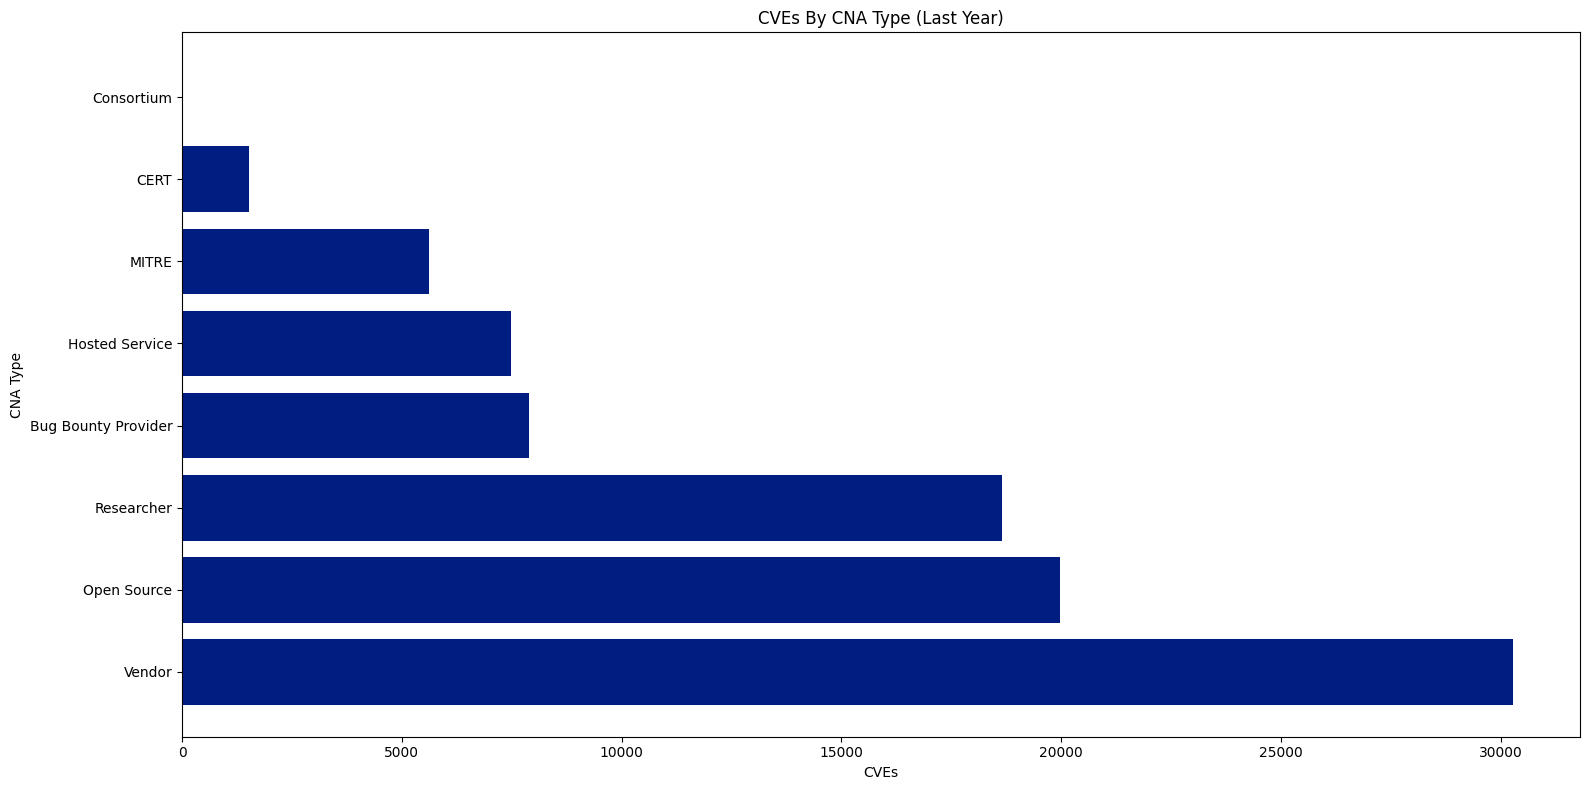

In [21]:
# Calculate frequency of CNA Types for the last year
cna_type_frequency_last_year = CVE_DF_Flat_LastYear['Type'].value_counts().reset_index()
cna_type_frequency_last_year.columns = ['Type', 'counts']
cna_type_frequency_last_year = cna_type_frequency_last_year[cna_type_frequency_last_year['counts'] > 1].head(20)

# Plot the top 20 CNA Types for the last year
plt.figure(figsize=(16, 8))
plt.barh("Type", "counts", data=cna_type_frequency_last_year, color="#001d82")
plt.xlabel("CVEs")
plt.ylabel("CNA Type")
plt.title("CVEs By CNA Type (Last Year)")

# Save the chart as a PNG file
plt.tight_layout()
plt.savefig("cna_type_frequency_last_year.png")
plt.show()

In [24]:
cna_type_frequency_last_year

,Type,counts
0,Vendor,30284
1,Open Source,19972
2,Researcher,18643
3,Bug Bounty Provider,7891
4,Hosted Service,7488
5,MITRE,5626
6,CERT,1519
7,Consortium,6


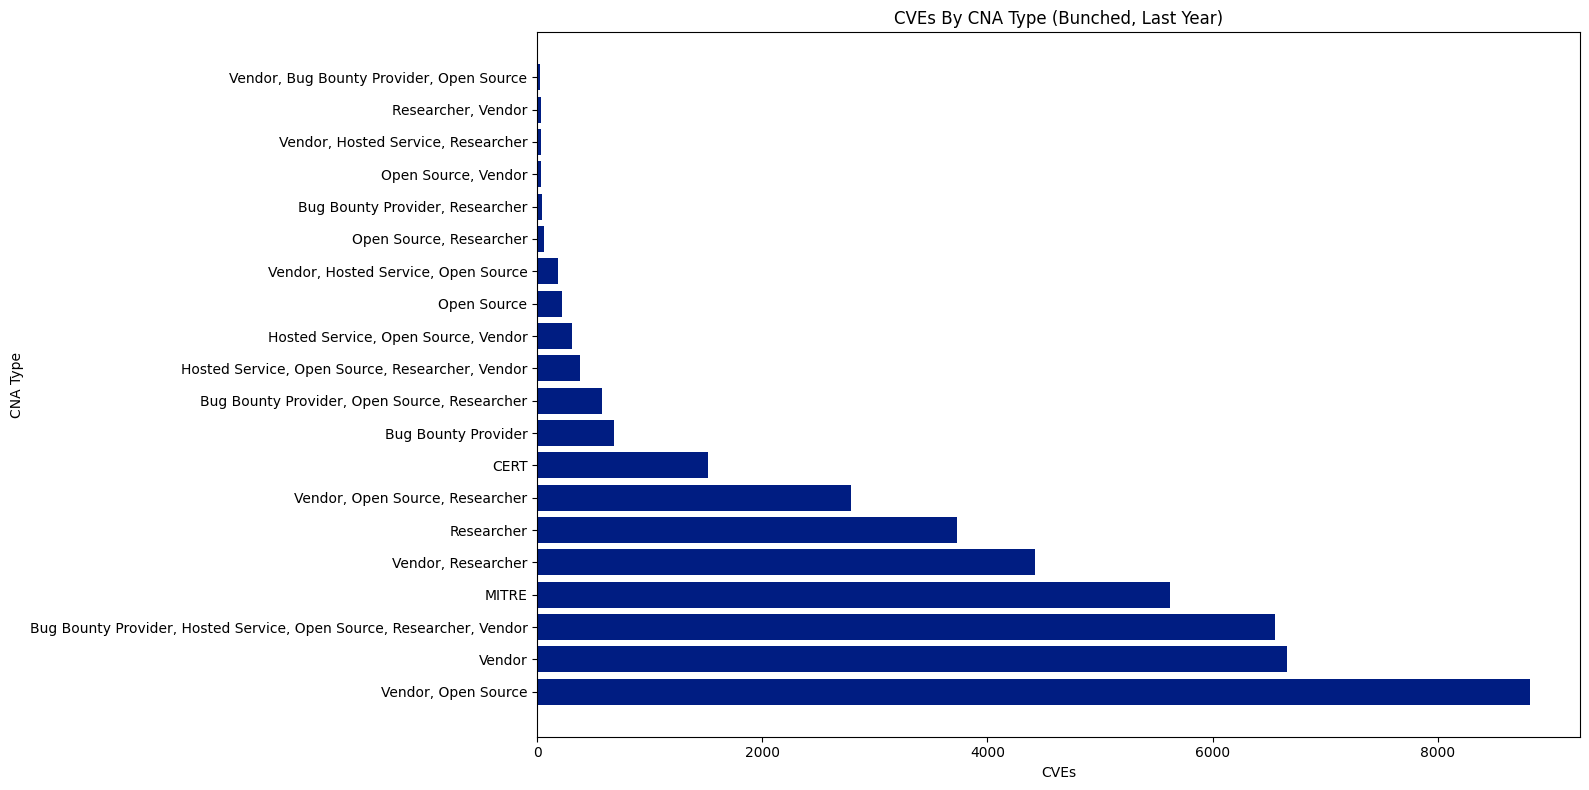

In [25]:
# Calculate frequency of CNA Types in CVE_DF_Bunched_LastYear
cna_type_frequency_bunched_last_year = CVE_DF_Bunched_LastYear['Type'].value_counts().reset_index()
cna_type_frequency_bunched_last_year.columns = ['Type', 'counts']
cna_type_frequency_bunched_last_year = cna_type_frequency_bunched_last_year[cna_type_frequency_bunched_last_year['counts'] > 1].head(20)

# Plot the top 20 CNA Types for CVE_DF_Bunched_LastYear
plt.figure(figsize=(16, 8))
plt.barh("Type", "counts", data=cna_type_frequency_bunched_last_year, color="#001d82")
plt.xlabel("CVEs")
plt.ylabel("CNA Type")
plt.title("CVEs By CNA Type (Bunched, Last Year)")

# Save the chart as a PNG file
plt.tight_layout()
plt.savefig("cna_type_frequency_bunched_last_year.png")
plt.show()

In [27]:
cna_type_frequency_bunched_last_year

,Type,counts
0,"Vendor, Open Source",8823
1,Vendor,6658
2,"Bug Bounty Provider, Hosted Service, Open Sour...",6554
3,MITRE,5626
4,"Vendor, Researcher",4421
5,Researcher,3730
6,"Vendor, Open Source, Researcher",2790
7,CERT,1517
8,Bug Bounty Provider,679
9,"Bug Bounty Provider, Open Source, Researcher",578
